In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Датасет уже разбит на две выборки, поэтому для нашего анализа соберем их в одну таблицу:

In [2]:
dfTrain = pd.read_csv('aps_failure_training_set.csv', na_values='na', decimal=',')

In [3]:
dfTest = pd.read_csv('aps_failure_test_set.csv', na_values='na', decimal=',')

In [4]:
dfTrain.shape, dfTest.shape

((60000, 171), (16000, 171))

In [5]:
df = dfTrain.append(dfTest, ignore_index = True)

In [6]:
df.shape

(76000, 171)

In [7]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


Посмотрим на распределение целевого признака. Видим большой дисбаланс классов.

In [8]:
vc=df['class'].value_counts()
vc

neg    74625
pos     1375
Name: class, dtype: int64

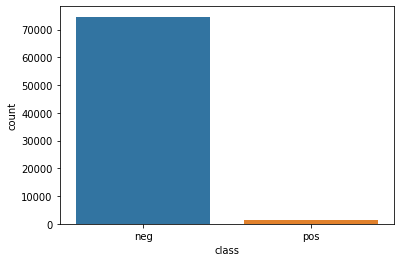

In [9]:
sns.countplot(df['class'])

## EDA

Вводим функцию для определения столбцов, в которых количество NaN превышает заданный порог:

In [10]:
# Функция возвращает список столбцов таблицы data, 
# в которых доля ячеек с NaN больше порога threshold
def DetectNaThr(data, threshold):
    rowNum = data.shape[0]
    rates = (data.isna().sum() / rowNum).sort_values(ascending = False)
    thrLen = len(rates[rates > threshold])
    dropList = rates.head(thrLen).index.tolist()
    return dropList

Удаляем столбцы, в которых NaN больше 40%

In [11]:
dropList0 = DetectNaThr(df, 0.4)

In [12]:
df0 = df.drop(labels = dropList0, axis = 1)

Удаляем строки, где есть NaN

In [13]:
df0.dropna(inplace = True)

In [14]:
df0.shape

(30858, 162)

In [15]:
def corr_feature_detect(data, target_variable, threshold=0.8):
    
    corrmat = data.drop(target_variable, axis=1).corr()

    corrmat = corrmat.abs().unstack().sort_values(ascending=False)

    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1]

    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    correlated_feats = []

    for row in corrmat.values:
        f1, f2, corr_value = row

        if not ((f1 in correlated_feats) | (f2 in correlated_feats)):
            f1_feat_len = corrmat[(corrmat.feature1==f1) | (corrmat.feature2==f1)].shape[0]
            f2_feat_len = corrmat[(corrmat.feature1==f2) | (corrmat.feature2==f2)].shape[0]

            if f1_feat_len >= f2_feat_len:
                correlated_feats.append(f1)
            else:
                correlated_feats.append(f2)
    
    return correlated_feats

In [16]:
target = 'class'

Определяем список признаков, после выбрасывания которых в матрице корреляций все внедиагональные значения 
станут меньше 0.8:

In [17]:
corrFeatures = corr_feature_detect(df0, target)

... и удаляем их:

In [18]:
df1 = df0.drop(labels = corrFeatures, axis = 1)

In [19]:
df1.shape

(30858, 105)

In [20]:
dropColList = dropList0 + corrFeatures

In [21]:
len(dropColList)

66

Смотрим на 'выбросы'

In [22]:
ds = df1.describe(percentiles = [0.99])
ds

,ac_000,ae_000,ag_000,ag_001,ag_006,ag_007,ag_008,ag_009,ai_000,ak_000,...,ea_000,eb_000,ec_00,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,3.085800e+04,30858.000000,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,...,30858.000000,3.085800e+04,30858.000000,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,30858.000000,30858.000000
mean,4.941825e+08,13.005898,3.520657e+02,4.078028e+02,1.977229e+06,6.395040e+05,4.628441e+04,4.476597e+03,8.100241e+03,1.481466e+03,...,2.685851,1.235536e+07,1699.269403,4.615703e+05,3.858235e+05,3.358649e+05,1.856189e+05,1.201115e+04,0.042128,0.318491
std,8.993144e+08,224.192103,2.812134e+04,1.216986e+04,1.782247e+06,9.086916e+05,1.523869e+05,6.388579e+04,1.278633e+05,9.953701e+04,...,72.115213,4.111283e+07,2072.373377,5.854349e+05,7.451858e+05,1.359892e+06,2.686022e+05,3.839477e+04,2.161941,14.138448
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,6.340000e+02,0.000000,0.000000e+00,0.000000e+00,1.694579e+06,5.048040e+05,2.383900e+04,3.660000e+02,0.000000e+00,0.000000e+00,...,0.000000,1.927600e+06,1221.000000,3.480210e+05,2.342920e+05,1.384900e+05,1.057360e+05,9.260000e+02,0.000000,0.000000
99%,2.130706e+09,326.000000,0.000000e+00,0.000000e+00,7.357253e+06,3.138960e+06,3.270324e+05,3.644658e+04,1.214864e+05,0.000000e+00,...,18.000000,1.297010e+08,9685.118000,2.296794e+06,3.386248e+06,4.481814e+06,1.197236e+06,1.565035e+05,0.000000,0.000000
max,2.130707e+09,21050.000000,3.376892e+06,1.150462e+06,7.763627e+07,6.334675e+07,1.590070e+07,5.468048e+06,1.048350e+07,1.044492e+07,...,8506.000000,1.322457e+09,47911.540000,3.411102e+07,2.811407e+07,1.195801e+08,8.291710e+06,2.528010e+06,340.000000,1720.000000


In [23]:
# Функция возвращает список столбцов таблицы data, 
# для которых отношение prst%-процентили к максимуму меньше eps
def DetectPrstThr(data, prst, eps):
    P1 = prst * 0.01
    rates = (data.quantile(P1) / data.max()).sort_values()
    thrLen = len(rates[rates < eps])
    dropList = rates.head(thrLen).index.tolist()
    return dropList

Удаляем столбцы, в которых отношение 99%-процентили к максимому меньше 0.01

In [24]:
dropListP = DetectPrstThr(df1, 99, 0.01)
dropListP.sort()
dropListP

['ag_000',
 'ag_001',
 'ag_009',
 'ak_000',
 'as_000',
 'at_000',
 'au_000',
 'ay_000',
 'ay_001',
 'ay_003',
 'ay_004',
 'ay_005',
 'ay_009',
 'az_007',
 'az_008',
 'az_009',
 'ch_000',
 'cn_000',
 'cn_009',
 'cs_008',
 'cs_009',
 'cy_000',
 'da_000',
 'df_000',
 'dg_000',
 'dh_000',
 'dj_000',
 'dk_000',
 'dl_000',
 'dz_000',
 'ea_000',
 'ef_000',
 'eg_000']

In [25]:
df2 = df1.drop(labels = dropListP, axis = 1)

In [26]:
dropColList = dropColList + dropListP

In [27]:
len(dropColList)

99

In [28]:
df2.shape

(30858, 72)

In [29]:
df2.describe()

,ac_000,ae_000,ag_006,ag_007,ag_008,ai_000,al_000,ao_000,ar_000,av_000,...,ds_000,du_000,dy_000,eb_000,ec_00,ee_005,ee_006,ee_007,ee_008,ee_009
count,3.085800e+04,30858.000000,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,30858.000000,30858.000000,...,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,30858.000000,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04,3.085800e+04
mean,4.941825e+08,13.005898,1.977229e+06,6.395040e+05,4.628441e+04,8.100241e+03,4.049286e+04,3.516460e+06,0.446367,1989.236308,...,1.222550e+05,5.575837e+06,9.642279e+03,1.235536e+07,1699.269403,4.615703e+05,3.858235e+05,3.358649e+05,1.856189e+05,1.201115e+04
std,8.993144e+08,224.192103,1.782247e+06,9.086916e+05,1.523869e+05,1.278633e+05,2.386628e+05,4.530613e+06,5.402477,6401.970032,...,1.526373e+05,1.063425e+07,5.823936e+04,4.111283e+07,2072.373377,5.854349e+05,7.451858e+05,1.359892e+06,2.686022e+05,3.839477e+04
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.171620e+05,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.560000e+02,0.000000,1.246946e+06,2.312150e+05,7.042000e+03,0.000000e+00,0.000000e+00,1.896108e+06,0.000000,306.000000,...,6.336800e+04,1.318200e+05,0.000000e+00,4.168650e+05,892.760000,2.445645e+05,1.515140e+05,6.737550e+04,1.138800e+04,0.000000e+00
50%,6.340000e+02,0.000000,1.694579e+06,5.048040e+05,2.383900e+04,0.000000e+00,0.000000e+00,2.274284e+06,0.000000,692.000000,...,8.820000e+04,9.947500e+05,0.000000e+00,1.927600e+06,1221.000000,3.480210e+05,2.342920e+05,1.384900e+05,1.057360e+05,9.260000e+02
75%,3.800000e+03,0.000000,2.309294e+06,8.183340e+05,5.293800e+04,0.000000e+00,7.560000e+02,3.415360e+06,0.000000,1796.000000,...,1.278615e+05,7.399630e+06,8.060000e+02,9.929000e+06,1830.120000,5.222460e+05,3.783975e+05,2.378580e+05,2.583315e+05,9.454000e+03
max,2.130707e+09,21050.000000,7.763627e+07,6.334675e+07,1.590070e+07,1.048350e+07,1.149018e+07,8.501810e+07,350.000000,299810.000000,...,3.322022e+06,1.873697e+08,3.115824e+06,1.322457e+09,47911.540000,3.411102e+07,2.811407e+07,1.195801e+08,8.291710e+06,2.528010e+06


Кодируем целевой признак:

In [30]:
df3 = pd.get_dummies(df2, columns=[target], drop_first=True)

In [31]:
df3.head()

,ac_000,ae_000,ag_006,ag_007,ag_008,ai_000,al_000,ao_000,ar_000,av_000,...,du_000,dy_000,eb_000,ec_00,ee_005,ee_006,ee_007,ee_008,ee_009,class_pos
0,2.130706e+09,0.0,3664156.0,1007684.0,25896.0,0.0,0.0,3655166.0,0.0,1012.0,...,14745580.0,0.0,2801180.0,2445.80,469792.0,339156.0,157956.0,73224.0,0.0,0
2,2.280000e+02,0.0,1883374.0,292936.0,12016.0,0.0,0.0,2173634.0,0.0,358.0,...,300240.0,0.0,1040120.0,1018.64,409564.0,320746.0,158022.0,95128.0,514.0,0
4,1.368000e+03,0.0,1800340.0,131646.0,4588.0,0.0,0.0,2618878.0,0.0,1788.0,...,457040.0,27588.0,21173050.0,1116.06,347188.0,286954.0,311560.0,433954.0,1218.0,0
5,2.130706e+09,0.0,1462836.0,449716.0,39000.0,0.0,0.0,1892752.0,0.0,1142.0,...,10244700.0,0.0,0.0,1013.14,300412.0,1534.0,338.0,856.0,0.0,0
7,2.130706e+09,0.0,4227340.0,1674278.0,59718.0,0.0,0.0,4916376.0,0.0,182.0,...,14438160.0,0.0,3537310.0,2018.08,1052166.0,1108672.0,341532.0,129504.0,7832.0,0


## Scaling

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [33]:
X = df3.drop(labels = 'class_pos', axis = 1)

In [34]:
y = df3['class_pos']

In [35]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 42, stratify = y)

In [36]:
# Нормализуем данные
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## ML

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score

In [38]:
def quality_report(prediction, actual, verbose=True):
    report_str = "Accuracy: \t {:.3f}\n" +\
                 "Precision: \t {:.3f}\n" +\
                 "Recall: \t {:.3f}\n" +\
                 "f1_score: \t {:.3f}\n" +\
                 "ROC-AUC: \t {:.3f}"
    
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual)
    recall = recall_score(prediction, actual)
    f1 = f1_score(prediction, actual)
    rocauc = roc_auc_score(prediction, actual)
    
    quality_list = [acc, precision, recall, f1, rocauc]
    
    if verbose:
        print("\n=== Quality Report ===")
        print(report_str.format(
            accuracy_score(prediction, actual),
            precision_score(prediction, actual),
            recall_score(prediction, actual),
            f1_score(prediction, actual),
            roc_auc_score(prediction, actual)
        ))
        print("======================\n")
    
    return quality_list

Применяем логистическую регрессию с  $L_2$-регуляризацией при $\lambda = 0.01$

In [39]:
modelLogR = LogisticRegression(C=100, solver="liblinear", penalty="l2")
logR = modelLogR.fit(X_train_scaled, y_train)
pred = modelLogR.predict(X_test_scaled)

In [40]:
quality_list_baseline = quality_report(pred, y_test)


=== Quality Report ===
Accuracy: 	 0.996
Precision: 	 0.581
Recall: 	 0.896
f1_score: 	 0.705
ROC-AUC: 	 0.946



Применяем логистическую регрессию с  $L_2$-регуляризацией при $\lambda = 0.01$ и балансировкой классов:

In [41]:
modelLogR = LogisticRegression(C=100, solver="liblinear", penalty="l2", class_weight="balanced")
logR = modelLogR.fit(X_train_scaled, y_train)
pred = modelLogR.predict(X_test_scaled)

In [42]:
quality_list_baseline = quality_report(pred, y_test)


=== Quality Report ===
Accuracy: 	 0.972
Precision: 	 0.905
Recall: 	 0.213
f1_score: 	 0.344
ROC-AUC: 	 0.606



Видим, что precision вырос, а остальные метрики упали.

Теперь применяем логистическую регрессию с $L_1$-регуляризацией при $\lambda=0.01$:

In [43]:
modelLogR = LogisticRegression(C=100, solver="liblinear", penalty="l1")
logRBest = modelLogR.fit(X_train_scaled, y_train)
pred = modelLogR.predict(X_test_scaled)

In [44]:
quality_list_baseline = quality_report(pred, y_test)


=== Quality Report ===
Accuracy: 	 0.997
Precision: 	 0.608
Recall: 	 0.938
f1_score: 	 0.738
ROC-AUC: 	 0.967



Видим, что по сравнению с $L_2$-регуляризацией все метрики выросли.

Применяем логистическую регрессию с  $L_1$-регуляризацией при $\lambda = 0.01$ и балансировкой классов:

In [45]:
modelLogR = LogisticRegression(C=100, solver="liblinear", penalty="l1", class_weight="balanced")
logR = modelLogR.fit(X_train_scaled, y_train)
pred = modelLogR.predict(X_test_scaled)

In [46]:
quality_list_baseline = quality_report(pred, y_test)


=== Quality Report ===
Accuracy: 	 0.971
Precision: 	 0.905
Recall: 	 0.202
f1_score: 	 0.331
ROC-AUC: 	 0.601



Видим, что ситуация такая же, как при $L_2$-регуляризации: precision вырос, а остальные метрики упали.

#### Попробуем сократить количество признаков

Посмотрим на распределение значений коэффициентов регресcии:

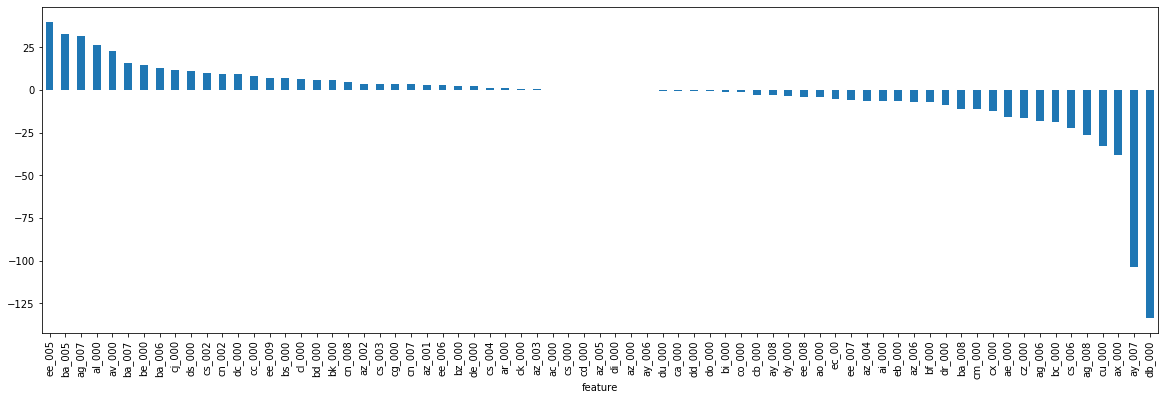

In [47]:
fW = pd.DataFrame({'feature': X.columns, 'weight': logRBest.coef_[0]})
fW.set_index('feature', inplace=True)
fW.sort_values(["weight"], ascending=False, inplace=True)
fW["weight"].plot(kind ='bar', figsize = (20, 6));

Выделим те коэффициенты, у которых абсолютное значение больше 5: 

In [48]:
fW.shape

(71, 1)

In [54]:
fW_ = fW[abs(fW['weight'])>5]

In [55]:
fWList = fW_.index.tolist()
len(fWList)

40

In [56]:
XShort = df3[fWList]

In [57]:
X_train, X_test, y_train, y_test = train_test_split (XShort, y, test_size = 0.3, random_state = 42, stratify = y)

In [58]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
modelLogR = LogisticRegression(C=100, solver="liblinear", penalty="l2")
logR = modelLogR.fit(X_train_scaled, y_train)
pred = modelLogR.predict(X_test_scaled)

In [60]:
quality_list_baseline = quality_report(pred, y_test)


=== Quality Report ===
Accuracy: 	 0.996
Precision: 	 0.581
Recall: 	 0.935
f1_score: 	 0.717
ROC-AUC: 	 0.966



In [61]:
modelLogR = LogisticRegression(C=100, solver="liblinear", penalty="l2", class_weight="balanced")
logR = modelLogR.fit(X_train_scaled, y_train)
pred = modelLogR.predict(X_test_scaled)

In [62]:
quality_list_baseline = quality_report(pred, y_test)


=== Quality Report ===
Accuracy: 	 0.974
Precision: 	 0.919
Recall: 	 0.222
f1_score: 	 0.358
ROC-AUC: 	 0.611



In [63]:
modelLogR = LogisticRegression(C=100, solver="liblinear", penalty="l1")
logRBest = modelLogR.fit(X_train_scaled, y_train)
pred = modelLogR.predict(X_test_scaled)

In [64]:
quality_list_baseline = quality_report(pred, y_test)


=== Quality Report ===
Accuracy: 	 0.997
Precision: 	 0.608
Recall: 	 0.938
f1_score: 	 0.738
ROC-AUC: 	 0.967



In [65]:
modelLogR = LogisticRegression(C=100, solver="liblinear", penalty="l1", class_weight="balanced")
logR = modelLogR.fit(X_train_scaled, y_train)
pred = modelLogR.predict(X_test_scaled)

In [66]:
quality_list_baseline = quality_report(pred, y_test)


=== Quality Report ===
Accuracy: 	 0.972
Precision: 	 0.919
Recall: 	 0.212
f1_score: 	 0.344
ROC-AUC: 	 0.606



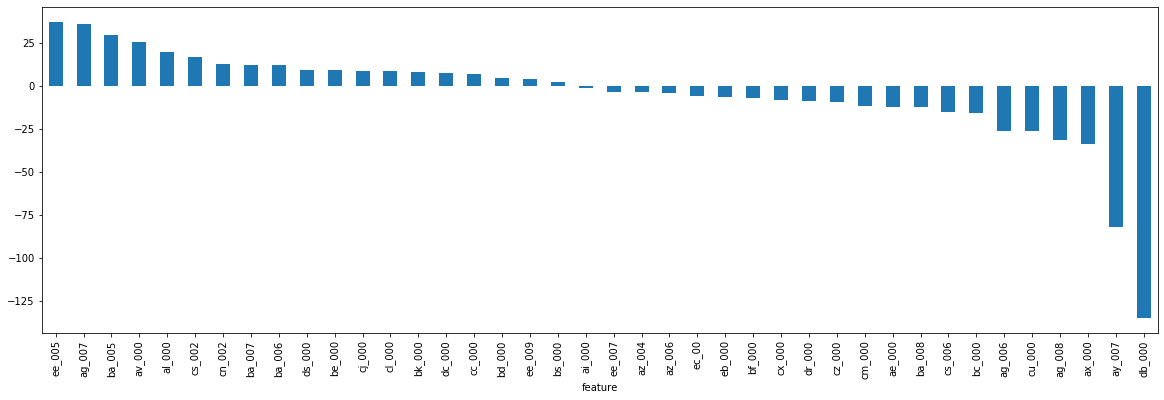

In [67]:
fW = pd.DataFrame({'feature': XShort.columns, 'weight': logRBest.coef_[0]})
fW.set_index('feature', inplace=True)
fW.sort_values(["weight"], ascending=False, inplace=True)
fW["weight"].plot(kind ='bar', figsize = (20, 6));

Итак, в случае $L_1$-регуляризации с $\lambda=0.01$ мы сократили количество признаков почти в два раза и сохранили метрики качества обучения: 
Accuracy: 	 0.997 \
Precision: 	 0.608 \
Recall: 	 0.938 \
f1_score: 	 0.738 \
ROC-AUC: 	 0.967